Thinkful Bootcamp Course

Author: Peter Gierke

Email: gierkep@gmail.com

Mentor: Shubhabrata roy

Date: 2017/06/10

The data comes from: https://www.kaggle.com/c/zillow-prize-1/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn import ensemble

%matplotlib inline

In [2]:
samplepath = 'C:\\Users\\Peter\\Desktop\\Capstones\\Supervised Learning Capstone\\sample_submission.csv'
samplesub = pd.read_csv(samplepath)

In [3]:
logerrorpath = 'C:\\Users\\Peter\\Desktop\\Capstones\\Supervised Learning Capstone\\train_2016.csv'
logerror = pd.read_csv(logerrorpath)

dfpath = 'C:\\Users\\Peter\\Desktop\\Capstones\\Supervised Learning Capstone\\properties_2016.csv'
df = pd.read_csv(dfpath, low_memory = False)

In [4]:
df.shape

(2985217, 58)

In [5]:
logerror.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [6]:
logerror.shape

(90811, 3)

In [7]:
df.dtypes

parcelid                          int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
heatingorsystemtypeid           float64
latitude                        float64


In [8]:
def eval_con_mat(conmat):
    print('Sensitivity:{}%'.format(round(conmat[1][1]/(conmat[1][0]+conmat[1][1]),4)*100))
    print('Specificity:{}%'.format(round(conmat[0][0]/(conmat[0][1]+conmat[0][0]),4)*100))

In [9]:
#merge property data onto logerror target set
train_df = pd.merge(logerror, df, on='parcelid', how='left')

In [10]:
(train_df.isnull().sum()/len(train_df))*100

parcelid                         0.000000
logerror                         0.000000
transactiondate                  0.000000
airconditioningtypeid           68.306703
architecturalstyletypeid        99.712590
basementsqft                    99.952649
bathroomcnt                      0.590237
bedroomcnt                       0.590237
buildingclasstypeid             99.982381
buildingqualitytypeid           36.831441
calculatedbathnbr                1.891841
decktypeid                      99.275418
finishedfloor1squarefeet        92.450254
calculatedfinishedsquarefeet     1.318122
finishedsquarefeet12             5.742696
finishedsquarefeet13            99.963661
finishedsquarefeet15            96.075365
finishedsquarefeet50            92.450254
finishedsquarefeet6             99.536400
fips                             0.590237
fireplacecnt                    89.420885
fullbathcnt                      1.891841
garagecarcnt                    67.033729
garagetotalsqft                 67

In [11]:
#elminate columns that are mostly NaN as they aren't going to be contributing any real varience
train_df.dropna(thresh=0.8*len(train_df), axis=1, inplace = True)

In [12]:
(train_df.isnull().sum()/len(train_df))*100

parcelid                         0.000000
logerror                         0.000000
transactiondate                  0.000000
bathroomcnt                      0.590237
bedroomcnt                       0.590237
calculatedbathnbr                1.891841
calculatedfinishedsquarefeet     1.318122
finishedsquarefeet12             5.742696
fips                             0.590237
fullbathcnt                      1.891841
latitude                         0.590237
longitude                        0.590237
lotsizesquarefeet               11.767297
propertycountylandusecode        0.591338
propertylandusetypeid            0.590237
rawcensustractandblock           0.590237
regionidcity                     2.575679
regionidcounty                   0.590237
regionidzip                      0.628778
roomcnt                          0.590237
yearbuilt                        1.422735
structuretaxvaluedollarcnt       1.008688
taxvaluedollarcnt                0.591338
assessmentyear                   0

In [13]:
train_df.shape

(90811, 27)

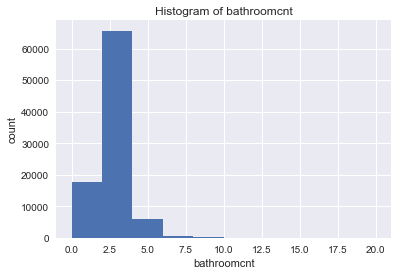

[  2.    3.5   3.    2.5   4.    1.    5.    5.5   1.5   8.    0.    4.5
   9.    7.    6.    nan  10.    6.5   7.5  12.   11.   20.    8.5  15. ]
% Nan:0.005902368655779586
Mean:2.2794738299639987
Median:2.0
Mode:0    2.0
dtype: float64


In [14]:
#inspect bathroom count
plt.hist(train_df['bathroomcnt'].dropna())
plt.xlabel('bathroomcnt')
plt.ylabel('count')
plt.title('Histogram of bathroomcnt')
plt.show()
print(train_df['bathroomcnt'].unique())
print('% Nan:{}'.format(train_df['bathroomcnt'].isnull().sum()/len(train_df)))
print('Mean:{}'.format(train_df['bathroomcnt'].mean()))
print('Median:{}'.format(train_df['bathroomcnt'].median()))
print('Mode:{}'.format(train_df['bathroomcnt'].mode()))

In [15]:
#fill Nan values with the median as there can't be .27 bathrooms
train_df['bathroomcnt'].fillna(train_df['bathroomcnt'].median(), inplace = True)

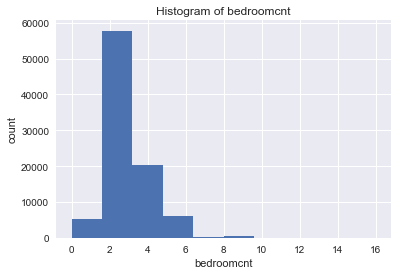

[  3.   4.   2.   5.   1.   6.   7.   0.  12.  11.  nan   8.   9.  10.  16.
  14.  13.  15.]
% Nan:0.005902368655779586
Mean:3.0318692882857934
Median:3.0
Mode:0    3.0
dtype: float64


In [16]:
#inspect bedroom count
plt.hist(train_df['bedroomcnt'].dropna())
plt.xlabel('bedroomcnt')
plt.ylabel('count')
plt.title('Histogram of bedroomcnt')
plt.show()
print(train_df['bedroomcnt'].unique())
print('% Nan:{}'.format(train_df['bedroomcnt'].isnull().sum()/len(train_df)))
print('Mean:{}'.format(train_df['bedroomcnt'].mean()))
print('Median:{}'.format(train_df['bedroomcnt'].median()))
print('Mode:{}'.format(train_df['bedroomcnt'].mode()))

In [17]:
#fill Nan values with the median as there can't be .03 bedrooms
train_df['bedroomcnt'].fillna(train_df['bedroomcnt'].median(), inplace = True)

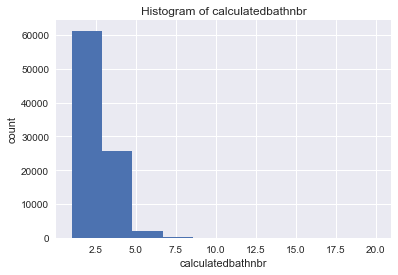

[  2.    3.5   3.    2.5   4.    1.    5.    5.5   1.5   8.    nan   4.5
   9.    7.    6.   10.    6.5   7.5  12.   11.   20.    8.5  15. ]
% Nan:0.018918412967592033
Mean:2.309216212272569
Median:2.0
Mode:0    2.0
dtype: float64


In [18]:
#inspect calculatedbathnbr count
plt.hist(train_df['calculatedbathnbr'].dropna())
plt.xlabel('calculatedbathnbr')
plt.ylabel('count')
plt.title('Histogram of calculatedbathnbr')
plt.show()
print(train_df['calculatedbathnbr'].unique())
print('% Nan:{}'.format(train_df['calculatedbathnbr'].isnull().sum()/len(train_df)))
print('Mean:{}'.format(train_df['calculatedbathnbr'].mean()))
print('Median:{}'.format(train_df['calculatedbathnbr'].median()))
print('Mode:{}'.format(train_df['calculatedbathnbr'].mode()))

In [19]:
#fill Nan values with the median as the data is not continuous
train_df['calculatedbathnbr'].fillna(train_df['calculatedbathnbr'].median(), inplace = True)

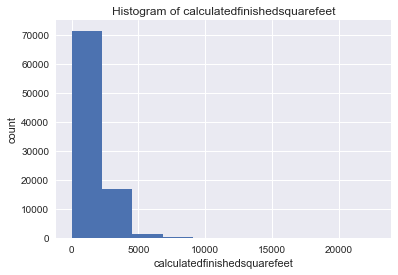

% Nan:0.01318122253911971
Unique values:[  1684.   2263.   2217. ...,   5937.  10681.  10014.]
No. of unique values:5102
Mean:1773.1859865645993
Median:1540.0
Mode:0    1200.0
dtype: float64


In [20]:
#inspect calculatedfinishedsquarefeet count
plt.hist(train_df['calculatedfinishedsquarefeet'].dropna())
plt.xlabel('calculatedfinishedsquarefeet')
plt.ylabel('count')
plt.title('Histogram of calculatedfinishedsquarefeet')
plt.show()
print('% Nan:{}'.format(train_df['calculatedfinishedsquarefeet'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['calculatedfinishedsquarefeet'].unique()))
print('No. of unique values:{}'.format(train_df['calculatedfinishedsquarefeet'].nunique()))
print('Mean:{}'.format(train_df['calculatedfinishedsquarefeet'].mean()))
print('Median:{}'.format(train_df['calculatedfinishedsquarefeet'].median()))
print('Mode:{}'.format(train_df['calculatedfinishedsquarefeet'].mode()))

In [21]:
#fill Nan values with the mean as the data is  continuous
train_df['calculatedfinishedsquarefeet'].fillna(train_df['calculatedfinishedsquarefeet'].mean(), inplace = True)

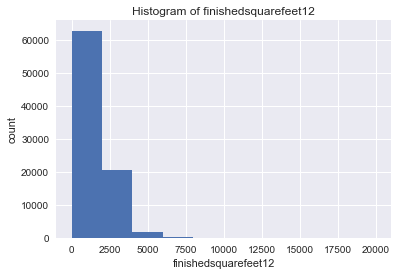

% Nan:0.05742696369382564
Unique values:[  1684.   2263.   2217. ...,   3758.  10681.  10014.]
No. of unique values:4982
Mean:1745.4545305855413
Median:1518.0
Mode:0    1200.0
dtype: float64


In [22]:
#inspect finishedsquarefeet12
plt.hist(train_df['finishedsquarefeet12'].dropna())
plt.xlabel('finishedsquarefeet12')
plt.ylabel('count')
plt.title('Histogram of finishedsquarefeet12')
plt.show()
print('% Nan:{}'.format(train_df['finishedsquarefeet12'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['finishedsquarefeet12'].unique()))
print('No. of unique values:{}'.format(train_df['finishedsquarefeet12'].nunique()))
print('Mean:{}'.format(train_df['finishedsquarefeet12'].mean()))
print('Median:{}'.format(train_df['finishedsquarefeet12'].median()))
print('Mode:{}'.format(train_df['finishedsquarefeet12'].mode()))

In [23]:
#fill Nan values with the mean as the data is  continuous
train_df['finishedsquarefeet12'].fillna(train_df['finishedsquarefeet12'].mean(), inplace = True)

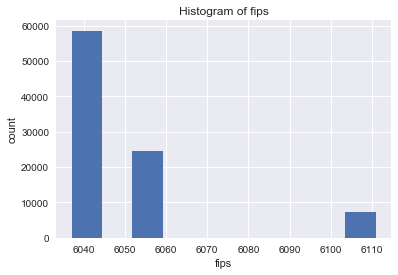

% Nan:0.005902368655779586
Unique values:[ 6037.  6059.  6111.    nan]
No. of unique values:3
Mean:6048.87055109388
Median:6037.0
Mode:0    6037.0
dtype: float64


In [24]:
#inspect fips
plt.hist(train_df['fips'].dropna())
plt.xlabel('fips')
plt.ylabel('count')
plt.title('Histogram of fips')
plt.show()
print('% Nan:{}'.format(train_df['fips'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['fips'].unique()))
print('No. of unique values:{}'.format(train_df['fips'].nunique()))
print('Mean:{}'.format(train_df['fips'].mean()))
print('Median:{}'.format(train_df['fips'].median()))
print('Mode:{}'.format(train_df['fips'].mode()))

In [25]:
#drop samples with nan values as fips is a location identifier and the average or median would not be meaningful
train_df.dropna(subset = ['fips'], inplace = True)

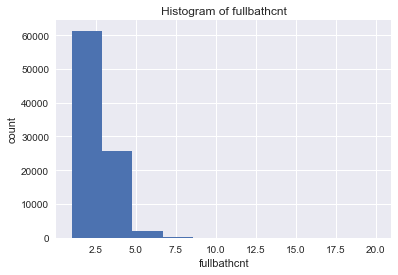

% Nan:0.013093325948490723
Unique values:[  2.   3.   4.   1.   5.   8.  nan   9.   7.   6.  10.  12.  11.  20.  15.]
No. of unique values:14
Mean:2.2412310731482834
Median:2.0
Mode:0    2.0
dtype: float64


In [26]:
#inspect fullbathcnt
plt.hist(train_df['fullbathcnt'].dropna())
plt.xlabel('fullbathcnt')
plt.ylabel('count')
plt.title('Histogram of fullbathcnt')
plt.show()
print('% Nan:{}'.format(train_df['fullbathcnt'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['fullbathcnt'].unique()))
print('No. of unique values:{}'.format(train_df['fullbathcnt'].nunique()))
print('Mean:{}'.format(train_df['fullbathcnt'].mean()))
print('Median:{}'.format(train_df['fullbathcnt'].median()))
print('Mode:{}'.format(train_df['fullbathcnt'].mode()))

In [27]:
#fill Nan values with the median as the data is not continuous and setting to a continuous value would be meaningless
train_df['fullbathcnt'].fillna(train_df['fullbathcnt'].median(), inplace = True)

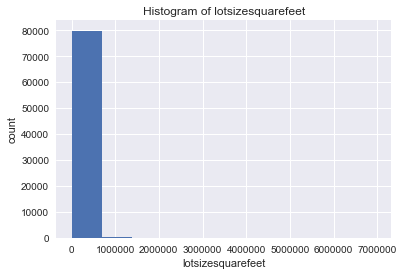

% Nan:0.11243422874549987
Unique values:[   7528.    3643.   11423. ...,   35223.   50431.  156910.]
No. of unique values:20016
Mean:29110.164176624025
Median:7200.0
Mode:0    6000.0
dtype: float64


In [28]:
#inspect lotsizesquarefeet
plt.hist(train_df['lotsizesquarefeet'].dropna())
plt.xlabel('lotsizesquarefeet')
plt.ylabel('count')
plt.title('Histogram of lotsizesquarefeet')
plt.show()
print('% Nan:{}'.format(train_df['lotsizesquarefeet'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['lotsizesquarefeet'].unique()))
print('No. of unique values:{}'.format(train_df['lotsizesquarefeet'].nunique()))
print('Mean:{}'.format(train_df['lotsizesquarefeet'].mean()))
print('Median:{}'.format(train_df['lotsizesquarefeet'].median()))
print('Mode:{}'.format(train_df['lotsizesquarefeet'].mode()))

In [29]:
#fill Nan values with the median as the mean is heaviy biased towards the outlier properties which are enormous
train_df['lotsizesquarefeet'].fillna(train_df['lotsizesquarefeet'].median(), inplace = True)

In [30]:
#inspect propertycountylandusecode
print('% Nan:{}'.format(train_df['propertycountylandusecode'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['propertycountylandusecode'].unique()))
print('No. of unique values:{}'.format(train_df['propertycountylandusecode'].nunique()))

% Nan:1.1077263915812794e-05
Unique values:['0100' '1' '010C' '122' '1129' '34' '1128' '010E' '0104' '0101' '0200'
 '0700' '1111' '01DC' '010D' '1110' '0400' '012C' '010V' '1116' '01HC'
 '010G' '0300' '010F' '1117' '0103' '38' '1210' '0111' '010M' '96' '135'
 '0108' '1014' '1112' '0201' '0109' '1310' '010H' '1410' '1222' '1321'
 '1720' '1011' '1432' '0401' '0102' '012D' '73' '105' '0110' '100V' '0130'
 '8800' '0303' '0210' '1012' '1333' '0114' '01DD' '020G' '040A' '012E'
 '020M' '040V' '070D' '1200' '030G' '1722' '6050' '1421' '010' nan '200'
 '0' '1420' '0131' '0301']
No. of unique values:77


In [31]:
#drop samples with nan values as propertycountylandusecode is catigorical variable and filling with unknown values wouldn't be accurate
train_df.dropna(subset = ['propertycountylandusecode'], inplace = True)

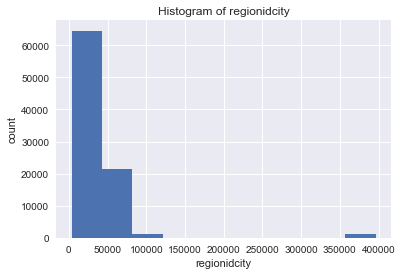

% Nan:0.01997252808117509
Unique values:[  12447.   32380.   47019.   17686.   29712.   24174.   13150.   25459.
   46098.  396054.   52650.   17150.   25218.   53655.   46298.   34780.
   47568.   24832.    5465.   40227.   54311.   10389.   21412.    6395.
   33252.   25458.   24384.   20008.   33836.    8384.   24812.   53571.
   51617.   45888.   45457.   15554.   24245.   16764.   27110.   40081.
   41673.   34278.   12773.   16389.   42150.   54970.      nan   52842.
   34543.   15237.   53636.   37688.   13693.    5534.   54722.   50749.
   51239.   27491.  118225.   27103.   13091.   33837.   50677.   10608.
   10723.   48424.   47762.    6021.    9840.   18874.   38032.   44833.
   24435.   12292.   10774.   37015.  396556.   45602.   33311.   33612.
   44116.   10241.   25974.   21778.   14634.   11626.   40009.   14542.
   30187.   32923.   26483.   26531.   14906.   14111.   26964.   18875.
   30908.   13716.   39306.  118914.   38980.   25621.   51861.  118878.
   34636.  

In [32]:
#inspect regionidcity
plt.hist(train_df['regionidcity'].dropna())
plt.xlabel('regionidcity')
plt.ylabel('count')
plt.title('Histogram of regionidcity')
plt.show()
print('% Nan:{}'.format(train_df['regionidcity'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['regionidcity'].unique()))
print('No. of unique values:{}'.format(train_df['regionidcity'].nunique()))
print('Mean:{}'.format(train_df['regionidcity'].mean()))
print('Median:{}'.format(train_df['regionidcity'].median()))
print('Mode:{}'.format(train_df['regionidcity'].mode()))

In [33]:
#inspect regionidzip
#plt.hist(train_df['regionidzip'].dropna())
plt.show()
print('% Nan:{}'.format(train_df['regionidzip'].isnull().sum()/len(train_df)))
print('No. of unique values:{}'.format(train_df['regionidzip'].nunique()))
print('Mean:{}'.format(train_df['regionidzip'].mean()))
print('Median:{}'.format(train_df['regionidzip'].median()))
print('Mode:{}'.format(train_df['regionidzip'].mode()))

% Nan:0.00038770853180317697
No. of unique values:388
Mean:96586.13545141237
Median:96393.0
Mode:0    97319.0
dtype: float64


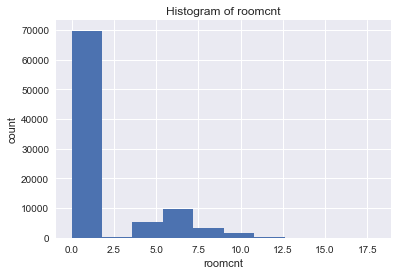

% Nan:0.0
Unique values:[  0.   8.   6.   5.   7.   4.   3.   9.  12.  11.  10.   2.   1.  13.  15.
  14.  18.]
No. of unique values:17
Mean:1.478532024724727
Median:0.0
Mode:0    0.0
dtype: float64


In [34]:
plt.hist(train_df['roomcnt'])
plt.xlabel('roomcnt')
plt.ylabel('count')
plt.title('Histogram of roomcnt')
plt.show()
print('% Nan:{}'.format(train_df['roomcnt'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['roomcnt'].unique()))
print('No. of unique values:{}'.format(train_df['roomcnt'].nunique()))
print('Mean:{}'.format(train_df['roomcnt'].mean()))
print('Median:{}'.format(train_df['roomcnt'].median()))
print('Mode:{}'.format(train_df['roomcnt'].mode()))

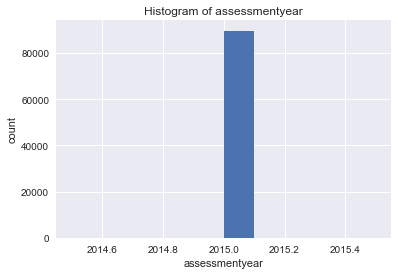

% Nan:0.0
Unique values:[ 2015.]
No. of unique values:1
Mean:2015.0
Median:2015.0
Mode:0    2015.0
dtype: float64


In [120]:
plt.hist(train_df['assessmentyear'])
plt.xlabel('assessmentyear')
plt.ylabel('count')
plt.title('Histogram of assessmentyear')
plt.show()
print('% Nan:{}'.format(train_df['assessmentyear'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['assessmentyear'].unique()))
print('No. of unique values:{}'.format(train_df['assessmentyear'].nunique()))
print('Mean:{}'.format(train_df['assessmentyear'].mean()))
print('Median:{}'.format(train_df['assessmentyear'].median()))
print('Mode:{}'.format(train_df['assessmentyear'].mode()))

In [35]:
#Well I think its safe to say that this variable is meaningless.  The majority of the properties are listed as having zero rooms
if 'roomcnt' in train_df.columns: del train_df['roomcnt']

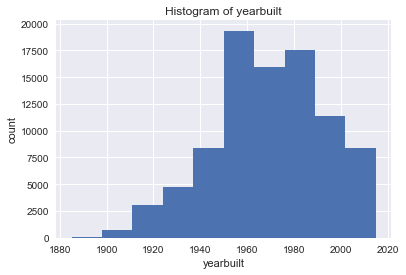

% Nan:0.008374504286948622
No. of unique values:130
Mean:1968.5323622064836
Median:1970.0
Mode:0    1955.0
dtype: float64


In [36]:
#inspect yearbuilt
plt.hist(train_df['yearbuilt'].dropna())
plt.xlabel('yearbuilt')
plt.ylabel('count')
plt.title('Histogram of yearbuilt')
plt.show()
print('% Nan:{}'.format(train_df['yearbuilt'].isnull().sum()/len(train_df)))
print('No. of unique values:{}'.format(train_df['yearbuilt'].nunique()))
print('Mean:{}'.format(train_df['yearbuilt'].mean()))
print('Median:{}'.format(train_df['yearbuilt'].median()))
print('Mode:{}'.format(train_df['yearbuilt'].mode()))

In [37]:
#fill Nan values with the median as the data isn't continuous
train_df['yearbuilt'].fillna(train_df['yearbuilt'].median(), inplace = True)

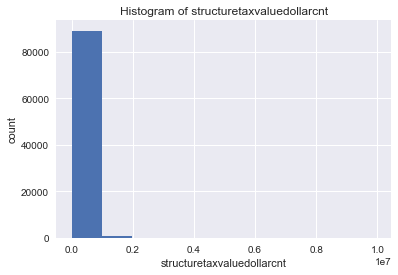

% Nan:0.004209406916720207
Unique values:[ 122754.  346458.   61994. ...,  180034.  192373.  132991.]
No. of unique values:55449
Mean:180091.2549780853
Median:132000.0
Mode:0    100000.0
dtype: float64


In [38]:
#inspect structuretaxvaluedollarcnt
plt.hist(train_df['structuretaxvaluedollarcnt'].dropna())
plt.xlabel('structuretaxvaluedollarcnt')
plt.ylabel('count')
plt.title('Histogram of structuretaxvaluedollarcnt')
plt.show()
print('% Nan:{}'.format(train_df['structuretaxvaluedollarcnt'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['structuretaxvaluedollarcnt'].unique()))
print('No. of unique values:{}'.format(train_df['structuretaxvaluedollarcnt'].nunique()))
print('Mean:{}'.format(train_df['structuretaxvaluedollarcnt'].mean()))
print('Median:{}'.format(train_df['structuretaxvaluedollarcnt'].median()))
print('Mode:{}'.format(train_df['structuretaxvaluedollarcnt'].mode()))

In [39]:
#fill Nan values with the median as the data is skewed towards the high end due to some properties being much more expensive
train_df['structuretaxvaluedollarcnt'].fillna(train_df['structuretaxvaluedollarcnt'].median(), inplace = True)

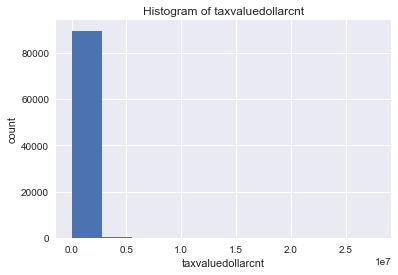

% Nan:1.1077386622947915e-05
Unique values:[ 360170.  585529.  119906. ...,  315288.   38096.  165869.]
No. of unique values:55937
Mean:457672.44256865286
Median:342872.0
Mode:0    350000.0
1    420000.0
2    500000.0
dtype: float64


In [40]:
#inspect taxvaluedollarcnt
plt.hist(train_df['taxvaluedollarcnt'].dropna())
plt.xlabel('taxvaluedollarcnt')
plt.ylabel('count')
plt.title('Histogram of taxvaluedollarcnt')
plt.show()
print('% Nan:{}'.format(train_df['taxvaluedollarcnt'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['taxvaluedollarcnt'].unique()))
print('No. of unique values:{}'.format(train_df['taxvaluedollarcnt'].nunique()))
print('Mean:{}'.format(train_df['taxvaluedollarcnt'].mean()))
print('Median:{}'.format(train_df['taxvaluedollarcnt'].median()))
print('Mode:{}'.format(train_df['taxvaluedollarcnt'].mode()))

In [41]:
#fill Nan values with the median as the data is skewed towards the high end due to some properties being much more expensive
train_df['taxvaluedollarcnt'].fillna(train_df['taxvaluedollarcnt'].median(), inplace = True)

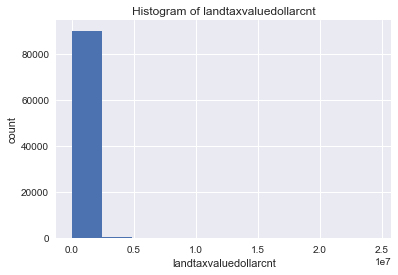

% Nan:1.1077386622947915e-05
Unique values:[ 237416.  239071.   57912. ...,  243265.  120020.   32878.]
No. of unique values:57066
Mean:278337.27839996456
Median:192980.0
Mode:0    20980.0
dtype: float64


In [42]:
#inspect taxvaluedollarcnt
plt.hist(train_df['landtaxvaluedollarcnt'].dropna())
plt.xlabel('landtaxvaluedollarcnt')
plt.ylabel('count')
plt.title('Histogram of landtaxvaluedollarcnt')
plt.show()
print('% Nan:{}'.format(train_df['landtaxvaluedollarcnt'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['landtaxvaluedollarcnt'].unique()))
print('No. of unique values:{}'.format(train_df['landtaxvaluedollarcnt'].nunique()))
print('Mean:{}'.format(train_df['landtaxvaluedollarcnt'].mean()))
print('Median:{}'.format(train_df['landtaxvaluedollarcnt'].median()))
print('Mode:{}'.format(train_df['landtaxvaluedollarcnt'].mode()))

In [43]:
#fill Nan values with the median as the data is skewed towards the high end due to some properties being much more expensive
train_df['landtaxvaluedollarcnt'].fillna(train_df['landtaxvaluedollarcnt'].median(), inplace = True)

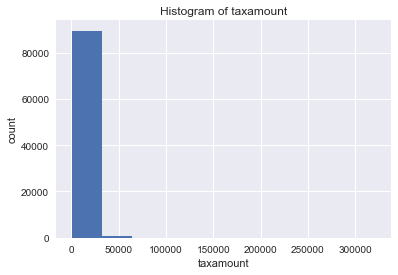

% Nan:6.646431973768749e-05
Unique values:[  6735.88  10153.02  11484.48 ...,   1886.54   1925.7    2285.57]
No. of unique values:85109
Mean:5983.9754478885125
Median:4542.719999999999
Mode:0    1544.26
dtype: float64


In [44]:
#inspect taxamount
plt.hist(train_df['taxamount'].dropna())
plt.xlabel('taxamount')
plt.ylabel('count')
plt.title('Histogram of taxamount')
plt.show()
print('% Nan:{}'.format(train_df['taxamount'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['taxamount'].unique()))
print('No. of unique values:{}'.format(train_df['taxamount'].nunique()))
print('Mean:{}'.format(train_df['taxamount'].mean()))
print('Median:{}'.format(train_df['taxamount'].median()))
print('Mode:{}'.format(train_df['taxamount'].mode()))

In [45]:
#fill Nan values with the median as the data is skewed towards the high end due to some properties being much more expensive
train_df['taxamount'].fillna(train_df['taxamount'].median(), inplace = True)

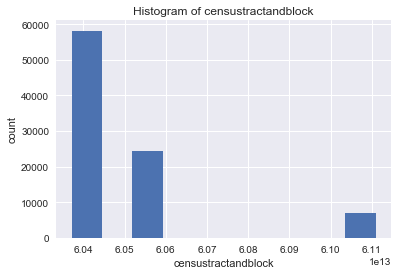

% Nan:0.0067018189068834885
Unique values:[  6.03710665e+13              nan   6.03746380e+13 ...,   6.11100151e+13
   6.03743270e+13   6.03754400e+13]
No. of unique values:42398
Mean:60491509845037.086
Median:60376200011005.0
Mode:0    6.037920e+13
dtype: float64


In [46]:
#inspect censustractandblock 
plt.hist(train_df['censustractandblock'].dropna())
plt.xlabel('censustractandblock')
plt.ylabel('count')
plt.title('Histogram of censustractandblock')
plt.show()
print('% Nan:{}'.format(train_df['censustractandblock'].isnull().sum()/len(train_df)))
print('Unique values:{}'.format(train_df['censustractandblock'].unique()))
print('No. of unique values:{}'.format(train_df['censustractandblock'].nunique()))
print('Mean:{}'.format(train_df['censustractandblock'].mean()))
print('Median:{}'.format(train_df['censustractandblock'].median()))
print('Mode:{}'.format(train_df['censustractandblock'].mode()))

In [124]:
train_df[['parcelid','logerror','transactiondate']].head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02
5,11509835,-0.2705,2016-01-02


In [47]:
#drop nan values as the data is catigorical and relates to census data that is unlikely to be relavant to property price anyway
train_df.dropna(subset = ['censustractandblock'], inplace = True)

In [48]:
#recheck the data for nan values
(train_df.isnull().sum()/len(train_df))*100

parcelid                        0.000000
logerror                        0.000000
transactiondate                 0.000000
bathroomcnt                     0.000000
bedroomcnt                      0.000000
calculatedbathnbr               0.000000
calculatedfinishedsquarefeet    0.000000
finishedsquarefeet12            0.000000
fips                            0.000000
fullbathcnt                     0.000000
latitude                        0.000000
longitude                       0.000000
lotsizesquarefeet               0.000000
propertycountylandusecode       0.000000
propertylandusetypeid           0.000000
rawcensustractandblock          0.000000
regionidcity                    1.898092
regionidcounty                  0.000000
regionidzip                     0.020074
yearbuilt                       0.000000
structuretaxvaluedollarcnt      0.000000
taxvaluedollarcnt               0.000000
assessmentyear                  0.000000
landtaxvaluedollarcnt           0.000000
taxamount       

In [49]:
#All clear.  Now that weve eliminated nan values from our data lets see what we can learn.

C:\Users\Peter\Anaconda3\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\Peter\Anaconda3\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


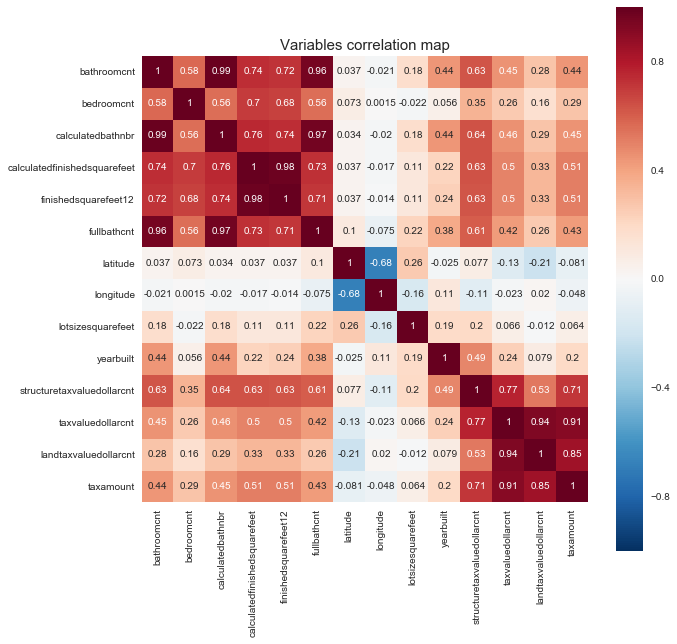

In [50]:
listofvariablesnottoplot = ['fips', #catigorical
                            'parcelid', #catigorical
                            'transactiondate',
                            'logerror', #target
                            'propertycountylandusecode', #catigorical
                            'regionidcity',
                            'regionidcounty', 
                            'regionidzip',
                            'rawcensustractandblock',
                            'propertylandusetypeid',
                            'assessmentyear',
                            'censustractandblock',
                            'transactiondate'] #catigorical
corrmat = train_df.drop(listofvariablesnottoplot, axis = 1).corr(method='spearman')
# Draw the heatmap using seaborn
plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=1., square=True, annot = True)
plt.title("Variables correlation map", fontsize=15)
plt.show()

In [51]:
#Lets do a qucik random forests check to see how we do with the data as it is.
rfr = ensemble.RandomForestRegressor()
cross_val_score(rfr, train_df.drop(listofvariablesnottoplot, axis = 1), train_df['logerror'], n_jobs = -1)

array([-0.12930679, -0.18723835, -0.14791206])

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df.drop(listofvariablesnottoplot, axis=1), train_df['logerror'],  test_size = 0.4)
rfr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [53]:
Y_ = rfr.predict(X_test)
mse = mean_squared_error(Y_test, Y_)
print('Mean squared error:{}'.format(mse))

Mean squared error:0.028925413141611615


In [54]:
#Seems there is alot of correlation between variables that describe whats in a house such as size and bathroom count.
#Theres also a strong correlation between the various taxes, which makes sense since they are based on one another.

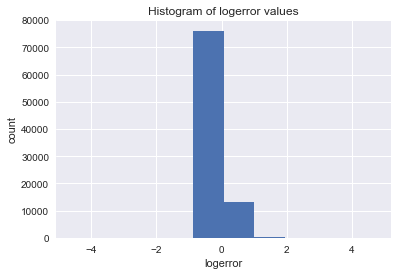

count    89669.000000
mean         0.011682
std          0.160438
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

In [55]:
#Lets do some initial exploration of the log error, our target variable for this competition
plt.hist(train_df['logerror'], bins = 10, range=[train_df['logerror'].min(), train_df['logerror'].max()])
plt.xlabel('logerror')
plt.ylabel('count')
plt.title('Histogram of logerror values')
plt.show()
train_df['logerror'].describe()

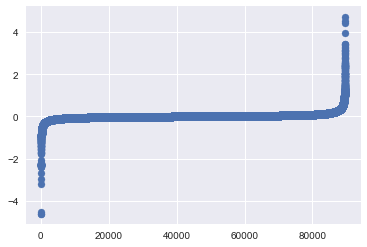

In [56]:
#Seems the vast majority of the logerror hovers around zero, so generally zillow does a good job predicting prices 
#But there are some extreme cases and thats what we are going to be looking at. Lets view the log error another way.
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.show()

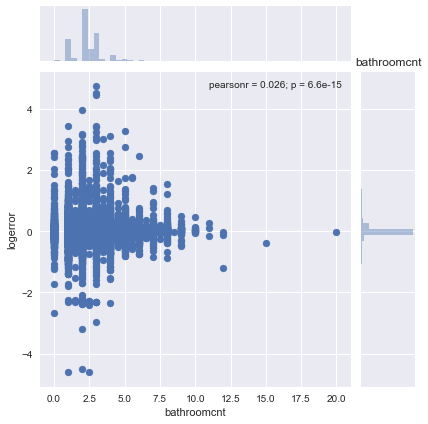

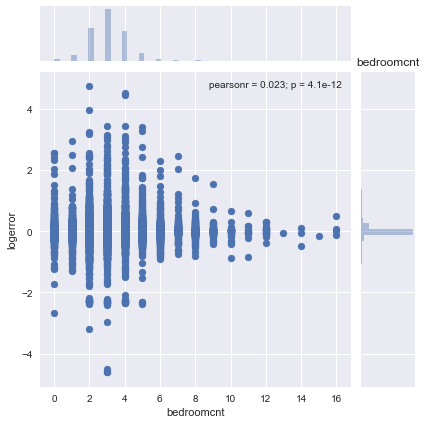

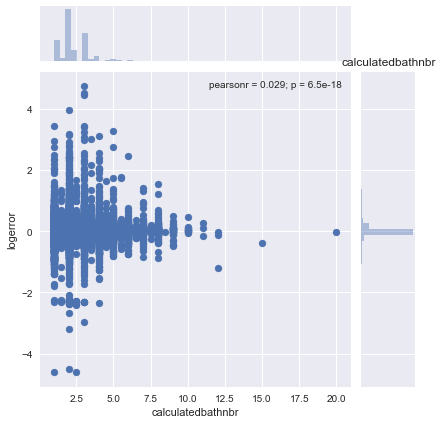

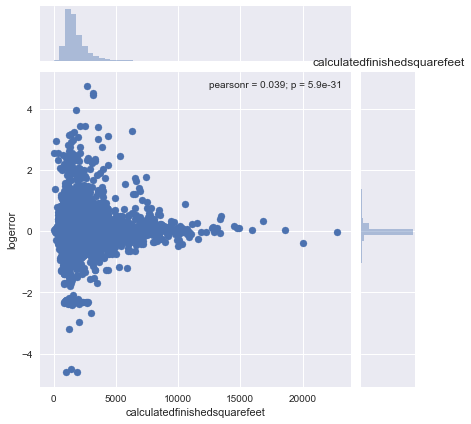

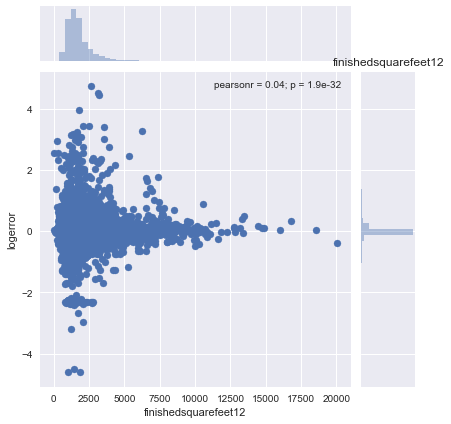

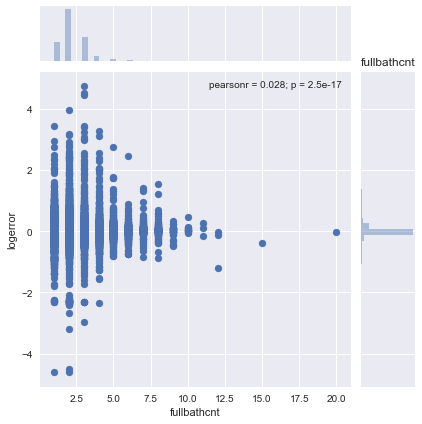

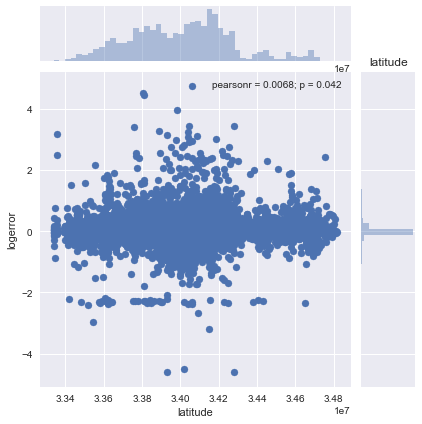

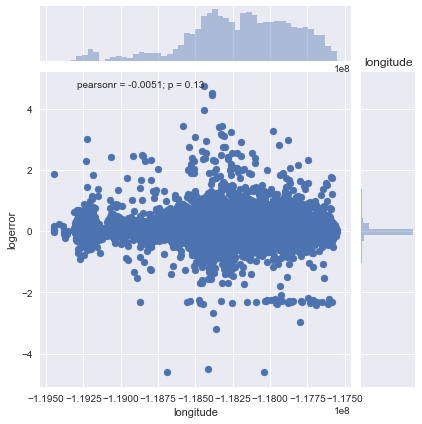

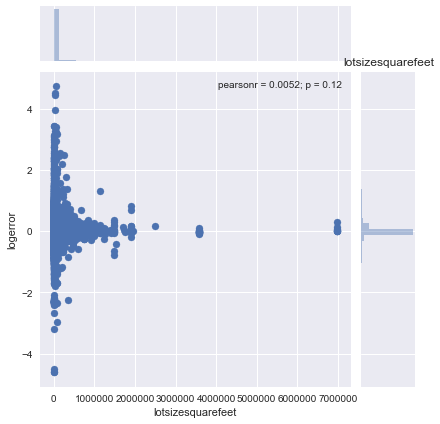

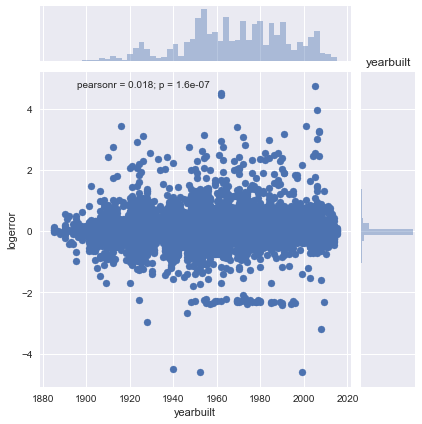

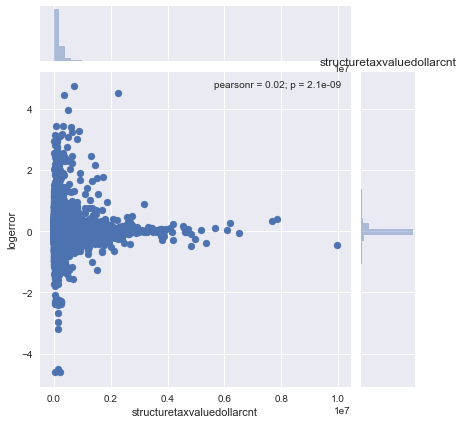

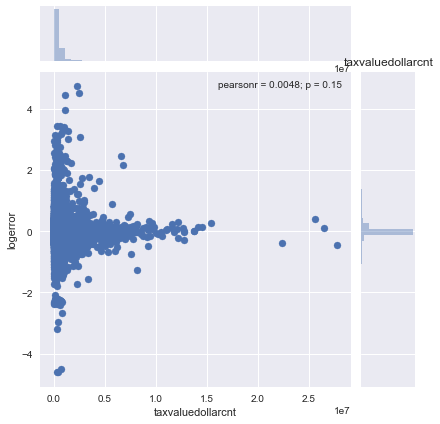

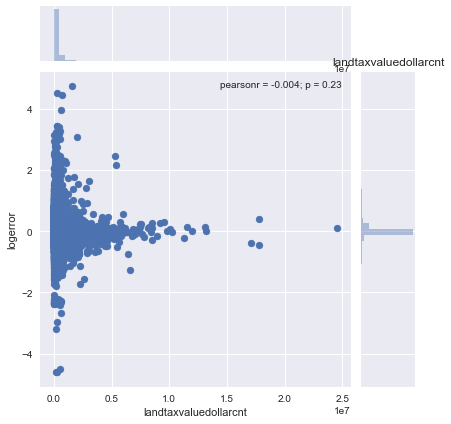

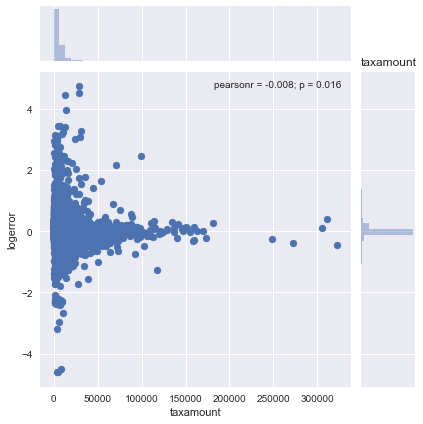

In [57]:
columnstoplot = train_df.drop(listofvariablesnottoplot, axis = 1).columns
for x in columnstoplot:
    sns.jointplot(train_df[x], train_df['logerror'])
    plt.title(x)
    plt.show()

In [58]:
#So, what we know from the variables we are working with is that small properties are much harder to predict than larger ones.
#This suggests that the log error in part may come from the need to sell.  
#Lets seem about properties that have been sold more than once.
multisell = train_df.duplicated(subset = 'parcelid')
resold_props = train_df[multisell == True]
multisell.value_counts()

False    89546
True       123
dtype: int64

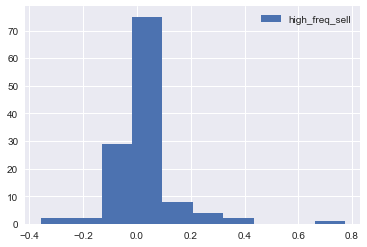

In [59]:
#So 123 properties were sold more than once.  Not enough to train on but could get some ideas from the log errors of them
plt.hist(resold_props['logerror'], label = 'high_freq_sell')
plt.legend()
plt.show()

In [60]:
#The range of the log error is actually smaller for these rapid sold properties than the data as a whole.

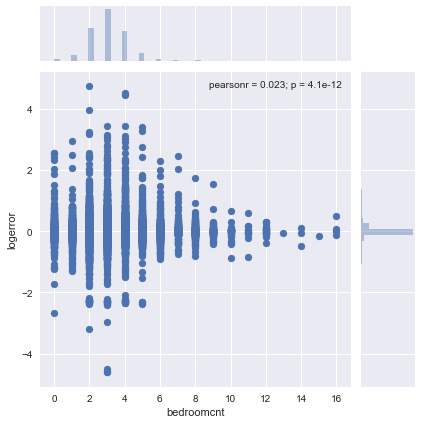

In [61]:
sns.jointplot(train_df['bedroomcnt'], train_df['logerror'])
plt.show()

In [62]:
#The interesting log error deviations, where logerror is different from zero, are very small part of the data overall.
#Lets see if we can come to any interesting conclusions about those segments of the data compared to the rest.
train_df['logerror'].describe()

count    89669.000000
mean         0.011682
std          0.160438
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

In [63]:
bottom_half = train_df[train_df['logerror'] < train_df['logerror'].median()]
bottom_quart = bottom_half['logerror'].median()
top_half = train_df[train_df['logerror'] > train_df['logerror'].median()]
upper_quart = top_half['logerror'].median()
train_df_normal = train_df[(train_df['logerror'] > bottom_quart) & (train_df['logerror'] < upper_quart)]
train_df_tails = train_df[(train_df['logerror'] <= bottom_quart) | (train_df['logerror'] >= upper_quart)]

In [64]:
bottom_quart

-0.0253

In [65]:
upper_quart

0.0392

In [66]:
#Now that we have separated out the data into low error and high error samples lets see if we can find any differences

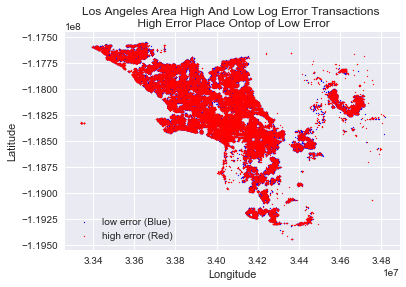

In [134]:
plt.scatter(train_df_normal.latitude, train_df_normal.longitude, c = 'b', label = 'low error (Blue)', s= 1)
plt.scatter(train_df_tails.latitude, train_df_tails.longitude, c = 'r', label = 'high error (Red)', s= 1)
plt.title('Los Angeles Area High And Low Log Error Transactions \n High Error Place Ontop of Low Error')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

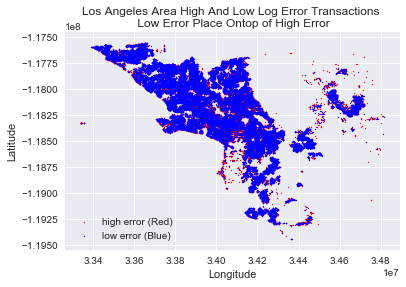

In [133]:
plt.scatter(train_df_tails.latitude, train_df_tails.longitude, c = 'r', label = 'high error (Red)', s= 1)
plt.scatter(train_df_normal.latitude, train_df_normal.longitude, c = 'b', label = 'low error (Blue)', s= 1)
plt.title('Los Angeles Area High And Low Log Error Transactions \n Low Error Place Ontop of High Error')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [69]:
#Geographically speaking there seems to be no relavance to the location of the property.  
#The high error and low error properties are in the exact same spaces.  Latitude and logitude are not meaningful in this data.
#But before we count it out entirely lets take some more extreme sample from the tails.

Now our datasets are imbalanced in size, the extremes dataset has 839 samples while the middle dataset has 88830 samples
Thats because our threshold for extreme is values of log error below -0.6300710616846973 or above 0.6534346343798308


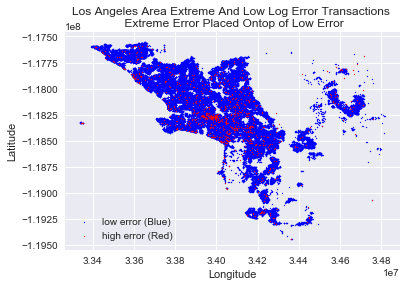

In [158]:
low_end = train_df['logerror'].mean() - 4 * train_df['logerror'].std()
high_end = train_df['logerror'].mean() + 4 * train_df['logerror'].std()
train_df_middle = train_df[(train_df['logerror'] > low_end) & (train_df['logerror'] < high_end)]
train_df_extreme = train_df[(train_df['logerror'] <= low_end) | (train_df['logerror'] >= high_end)]
print('Now our datasets are imbalanced in size, the extremes dataset has {} samples while the middle dataset has {} samples'
     .format(len(train_df_extreme), len(train_df_middle)))
print('Thats because our threshold for extreme is values of log error below {} or above {}'.format(low_end, high_end))
plt.scatter(train_df_middle.latitude, train_df_middle.longitude, c = 'b', label = 'low error (Blue)', s = 1)
plt.scatter(train_df_extreme.latitude, train_df_extreme.longitude, c = 'r', label = 'high error (Red)', s = 1)
plt.title('Los Angeles Area Extreme And Low Log Error Transactions \n Extreme Error Placed Ontop of Low Error')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

Now our datasets are imbalanced in size, the extremes dataset has 268 samples while the middle dataset has 89401 samples
Thats because our threshold for extreme is values of log error below -1.1113856977088954 or above 1.1347492704040287


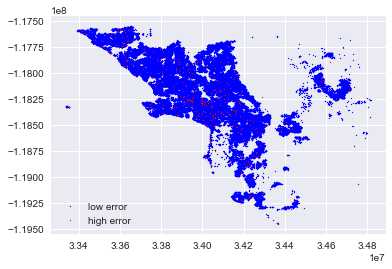

In [156]:
super_low_end = train_df['logerror'].mean() -  7 * train_df['logerror'].std()
super_high_end = train_df['logerror'].mean() + 7 * train_df['logerror'].std()
train_df_super_middle = train_df[(train_df['logerror'] > super_low_end) & (train_df['logerror'] < super_high_end)]
train_df_super_extreme = train_df[(train_df['logerror'] <= super_low_end) | (train_df['logerror'] >= super_high_end)]
print('Now our datasets are imbalanced in size, the extremes dataset has {} samples while the middle dataset has {} samples'
     .format(len(train_df_super_extreme), len(train_df_super_middle)))
print('Thats because our threshold for extreme is values of log error below {} or above {}'.format(super_low_end, super_high_end))
plt.scatter(train_df_super_middle.latitude, train_df_super_middle.longitude, c = 'b', label = 'low error', s = 1)
plt.scatter(train_df_super_extreme.latitude, train_df_super_extreme.longitude, c = 'r', label = 'high error', s = 1)
plt.legend()
plt.show()

In [73]:
#When looking the high error of 3 standard deviations from the mean it looks like the high error is at the core of the 
#geographical area that we are mapping in some clustering.

In [74]:
#There is the possibility that the time of year that the property was sold affects the price.  Lets take a look at that.
train_df_normal['transactiondate'].tail()

90801    2016-12-30
90802    2016-12-30
90803    2016-12-30
90804    2016-12-30
90806    2016-12-30
Name: transactiondate, dtype: object

In [75]:
train_df_normal['Monthofsale'] = train_df_normal['transactiondate'].str[5:7]
train_df_tails['Monthofsale'] = train_df_tails['transactiondate'].str[5:7]

C:\Users\Peter\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Peter\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


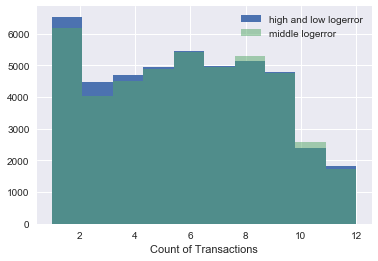

In [76]:
plt.hist(train_df_tails['Monthofsale'].astype(int), label = 'high and low logerror')
plt.hist(train_df_normal['Monthofsale'].astype(int), label = 'middle logerror', alpha = .5)
plt.xlabel('Month')
plt.xlabel('Count of Transactions')
plt.legend()
plt.show()

In [77]:
#The error by month of sale looks pretty much the same, but just in case lets take a look at the more extreme example as before
train_df_middle['Monthofsale'] = train_df_middle['transactiondate'].str[5:7]
train_df_extreme['Monthofsale'] = train_df_extreme['transactiondate'].str[5:7]

C:\Users\Peter\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Peter\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


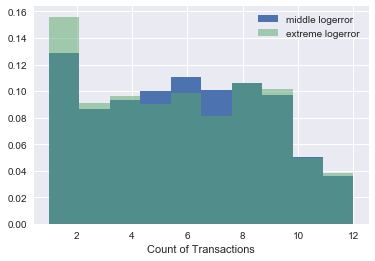

In [78]:
plt.hist(train_df_middle['Monthofsale'].astype(int), normed = True, label = 'middle logerror')
plt.hist(train_df_extreme['Monthofsale'].astype(int), normed = True, alpha = 0.5, label = 'extreme logerror')
plt.xlabel('Month')
plt.xlabel('Count of Transactions')
plt.legend()
plt.show()

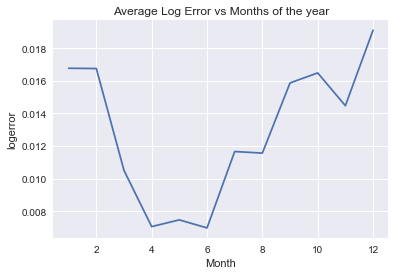

In [79]:
train_df_months = train_df.copy()
train_df_months['Monthofsale'] = train_df_months['transactiondate'].str[5:7]
plt.plot(train_df_months.groupby('Monthofsale').mean().logerror)
plt.title('Average Log Error vs Months of the year')
plt.ylabel('logerror')
plt.xlabel('Month')
plt.show()

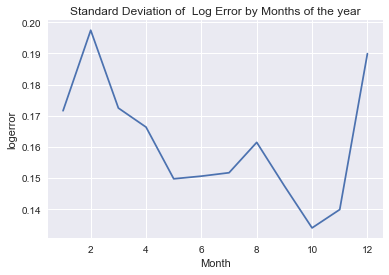

In [80]:
train_df_months = train_df.copy()
train_df_months['Monthofsale'] = train_df_months['transactiondate'].str[5:7]
plt.plot(train_df_months.groupby('Monthofsale').std().logerror)
plt.title('Standard Deviation of  Log Error by Months of the year')
plt.ylabel('logerror')
plt.xlabel('Month')
plt.show()

C:\Users\Peter\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


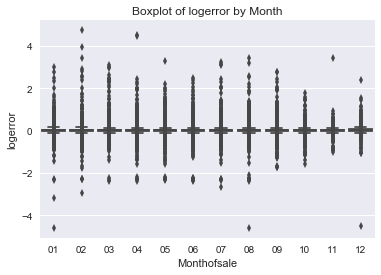

In [81]:
sns.boxplot(train_df_months.logerror, groupby = train_df_months.Monthofsale)
plt.title('Boxplot of logerror by Month')
plt.show()

In [82]:
#Calculate Std Devs for year and months.  To be use lated for predictions by month.
logerrorstd = train_df_months.logerror.std()
octlogerrorstd = train_df_months[train_df_months['Monthofsale'] == '10'].logerror.std()
novlogerrorstd = train_df_months[train_df_months['Monthofsale'] == '11'].logerror.std()
declogerrorstd = train_df_months[train_df_months['Monthofsale'] == '12'].logerror.std()

In [83]:
#Calculate Averages for year and months.  To be use lated for predictions by month.
avglogerror = train_df_months.logerror.mean()
octlogerror = train_df_months[train_df_months['Monthofsale'] == '10'].logerror.mean()
novlogerror = train_df_months[train_df_months['Monthofsale'] == '11'].logerror.mean()
declogerror = train_df_months[train_df_months['Monthofsale'] == '12'].logerror.mean()

In [84]:
#Its clear that as we mentioned before, the higher log error property sales occur on properties lith a lower overall price

In [85]:
#Lets check back with the random forest we ran and see if we can find anything interesting from the feature importances
X = train_df.drop(listofvariablesnottoplot, axis = 1)
rfr.fit(X, train_df['logerror'])
feature_importance=rfr.feature_importances_

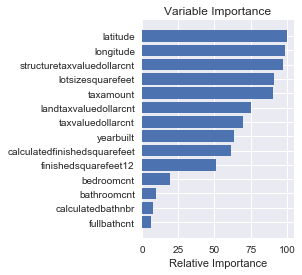

In [86]:
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [87]:
#According to random forests feature importance lotsize is the most influential in predicting logerror.  Lets another look.
#Lotsizesquarefeet was originally the data with the most Nan and we filled with the median to avoid bias towards the large props

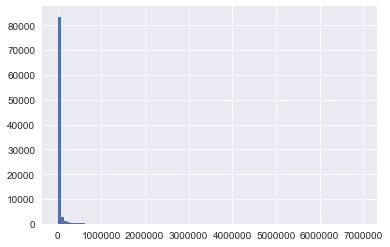

count    8.966900e+04
mean     2.655625e+04
std      1.146099e+05
min      1.670000e+02
25%      5.958000e+03
50%      7.200000e+03
75%      1.042500e+04
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64


In [88]:
plt.hist(train_df['lotsizesquarefeet'], bins = 100)
plt.show()
print(train_df['lotsizesquarefeet'].describe())

In [89]:
len(train_df_extreme)

839

In [90]:
len(train_df_middle)

88830

In [91]:
#Well lot size is certainly clearer than other variables that the logerror is more significant with larger properties
#But how can we use this?  lot size was the one variable without high correlation to anything. Lets see how lot size compares

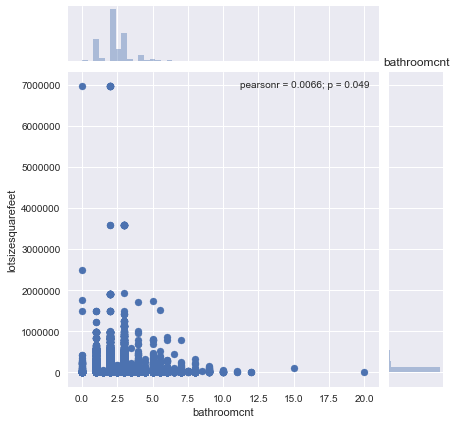

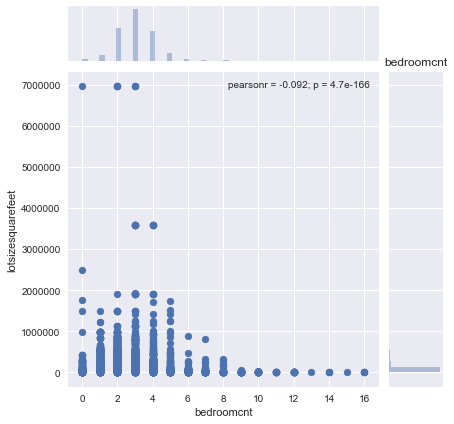

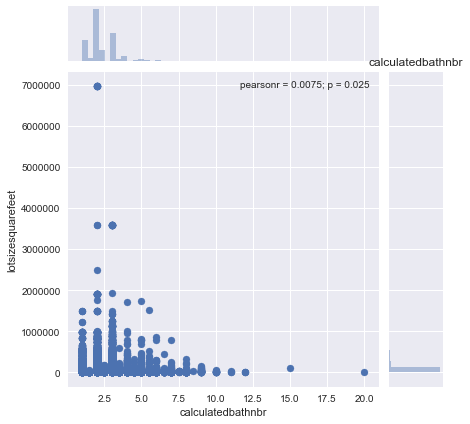

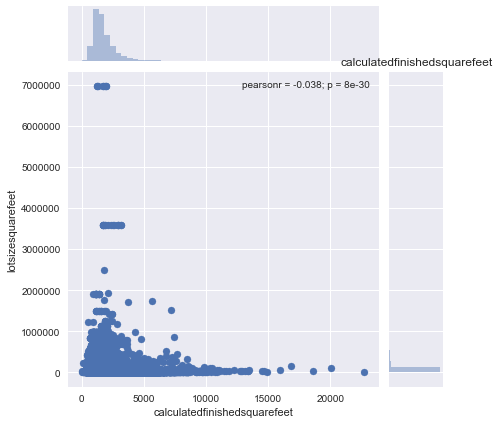

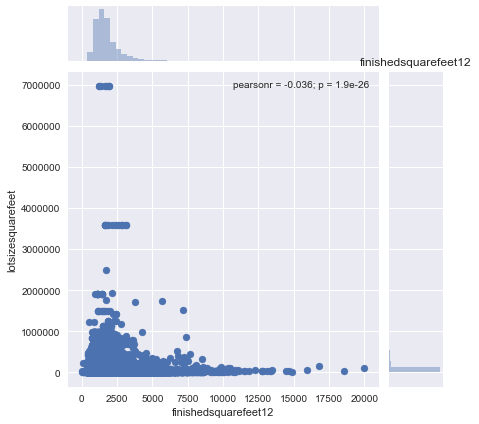

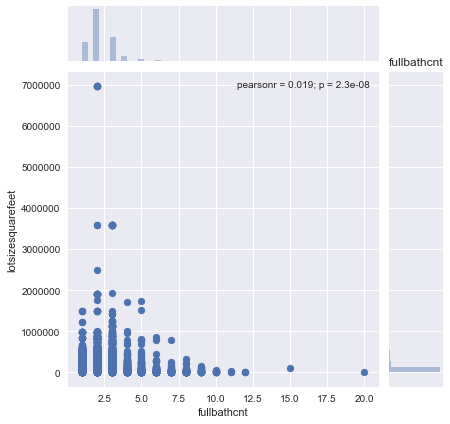

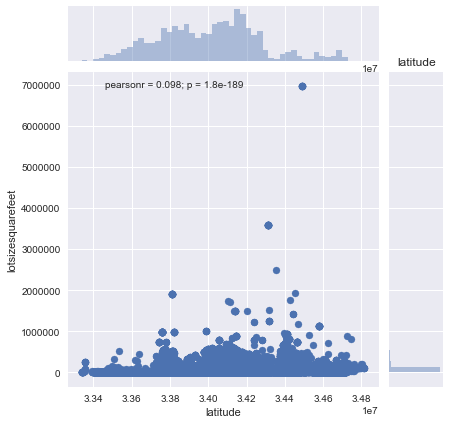

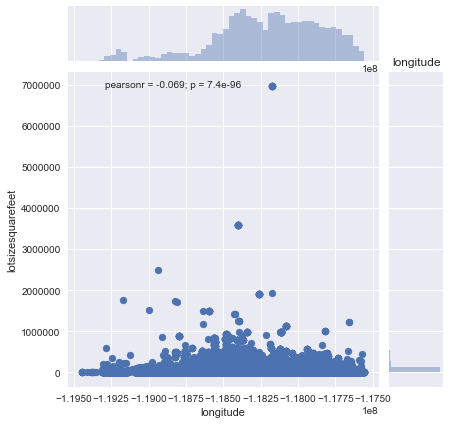

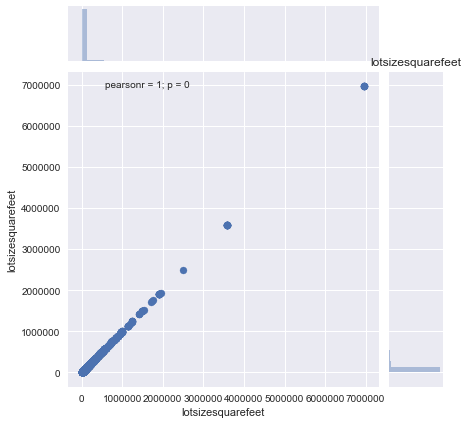

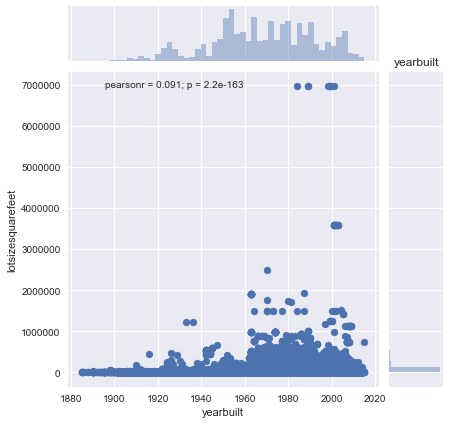

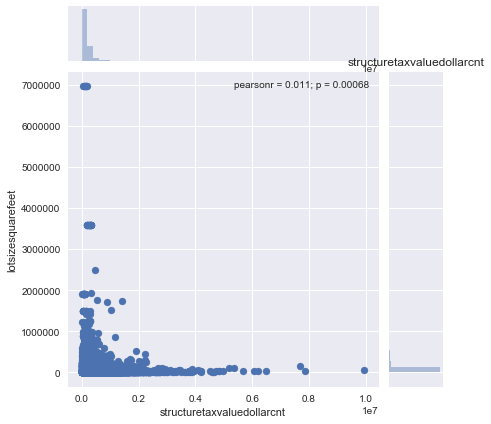

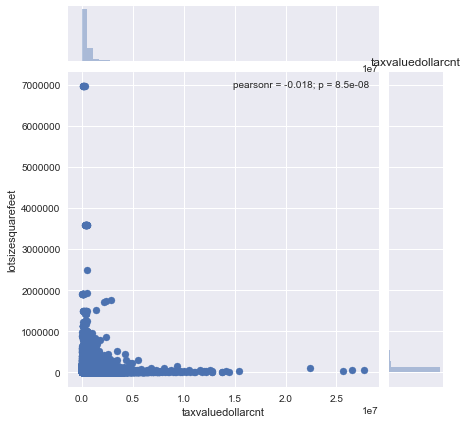

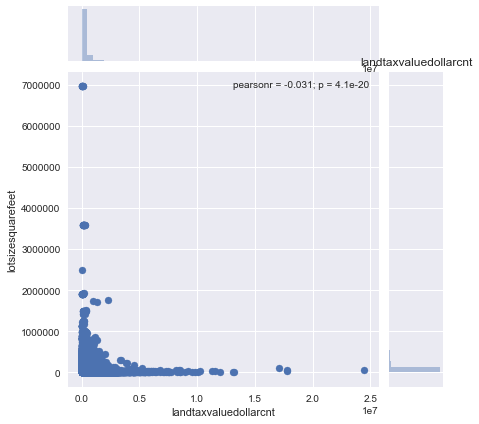

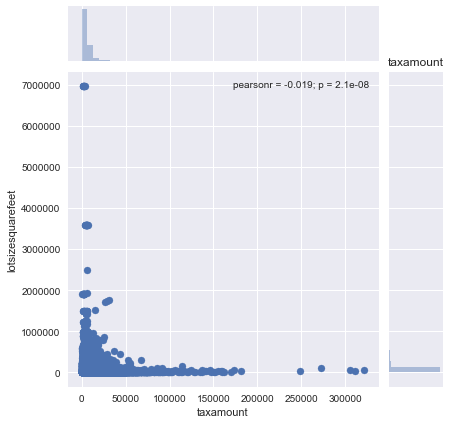

In [92]:
columnstoplot = train_df.drop(listofvariablesnottoplot, axis = 1).columns
for x in columnstoplot:
    sns.jointplot(train_df[x], train_df['lotsizesquarefeet'])
    plt.title(x)
    plt.show()

In [93]:
#So it seems that we have no obvious paths with the data as it is, maybe worth cutting the log error into different segments
#and trying to predict them that way.

In [94]:
#Lets try out some regression methods and see what comes out on top

In [95]:
from sklearn.neighbors import KNeighborsRegressor
KNN = KNeighborsRegressor()
KNNscore = cross_val_score(KNN, train_df.drop(listofvariablesnottoplot, axis = 1), train_df['logerror'], cv = 10, scoring = 'neg_mean_absolute_error')

In [96]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
RFRscore = cross_val_score(rfr, train_df.drop(listofvariablesnottoplot, axis = 1), train_df['logerror'], cv = 10, scoring = 'neg_mean_absolute_error')

In [97]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbrscore = cross_val_score(gbr, train_df.drop(listofvariablesnottoplot, axis = 1), train_df['logerror'], cv = 10, scoring = 'neg_mean_absolute_error')

In [98]:
xgbr = xgboost.XGBRegressor()
XGBscore = cross_val_score(xgbr, train_df.drop(listofvariablesnottoplot, axis = 1), train_df['logerror'], cv = 10, scoring = 'neg_mean_absolute_error')

In [99]:
scores = pd.DataFrame()
scores['KNN'] = KNNscore*-1
scores['RFR'] = RFRscore*-1
scores['GBR'] = gbrscore*-1
scores['XGB'] = XGBscore*-1

C:\Users\Peter\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


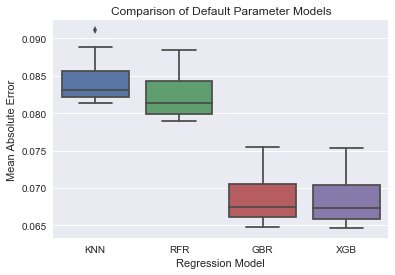

In [100]:
sns.boxplot(scores)
plt.xlabel('Regression Model')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Default Parameter Models')
plt.show()

In [101]:
train_df_redux = train_df[['calculatedfinishedsquarefeet','lotsizesquarefeet','taxamount','logerror','yearbuilt','latitude','longitude','finishedsquarefeet12','structuretaxvaluedollarcnt','taxvaluedollarcnt']]

In [109]:
test_data = df[['parcelid','calculatedfinishedsquarefeet','lotsizesquarefeet','taxamount','yearbuilt','latitude','longitude','finishedsquarefeet12','structuretaxvaluedollarcnt','taxvaluedollarcnt']]

test_data['calculatedfinishedsquarefeet'].fillna(test_data['calculatedfinishedsquarefeet'].mean(), inplace = True)
test_data['lotsizesquarefeet'].fillna(test_data['lotsizesquarefeet'].median(), inplace = True)
test_data['taxamount'].fillna(test_data['taxamount'].median(), inplace = True)
test_data['yearbuilt'].fillna(test_data['yearbuilt'].median(), inplace = True)
test_data['latitude'].fillna(test_data['latitude'].median(), inplace = True)
test_data['longitude'].fillna(test_data['longitude'].median(), inplace = True)
test_data['finishedsquarefeet12'].fillna(test_data['finishedsquarefeet12'].median(), inplace = True)
test_data['structuretaxvaluedollarcnt'].fillna(test_data['structuretaxvaluedollarcnt'].median(), inplace = True)
test_data['taxvaluedollarcnt'].fillna(test_data['taxvaluedollarcnt'].median(), inplace = True)

test_data = pd.merge(samplesub, test_data, left_on='ParcelId', right_on='parcelid', how='left')

C:\Users\Peter\Anaconda3\lib\site-packages\pandas\core\generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [110]:
xgbr2 = xgboost.XGBRegressor(base_score=0.5, 
                            booster='gblinear', 
                            colsample_bylevel=1,
                            colsample_bytree=1, 
                            gamma=0, 
                            eval_metric = 'mae', 
                            learning_rate=1, 
                            max_delta_step=0,
                            max_depth=3, 
                            min_child_weight=1, 
                            missing=None, 
                            n_estimators=2000,
                            n_jobs=-1, 
                            nthread=None, 
                            objective='reg:linear', 
                            random_state=0,
                            reg_alpha=0, 
                            reg_lambda=1, 
                            scale_pos_weight=1, 
                            seed=None,
                            silent=True, 
                            subsample=1)
tunedxgbscore = cross_val_score(xgbr2, train_df_redux.drop('logerror', axis = 1), train_df_redux['logerror'], cv = 10, scoring = 'neg_mean_absolute_error')


In [111]:
gbr2 = GradientBoostingRegressor(alpha=0.87, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=150,
             presort='auto', random_state=None, subsample=0.98, verbose=0,
             warm_start=False)
tunedgbrscore = cross_val_score(gbr2, train_df_redux.drop('logerror', axis = 1), train_df_redux['logerror'], cv = 10, scoring = 'neg_mean_absolute_error')

C:\Users\Peter\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


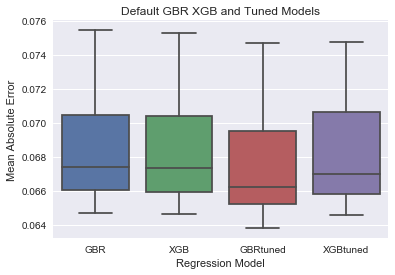

In [112]:
scores['GBRtuned'] = tunedgbrscore*-1
scores['XGBtuned'] = tunedxgbscore*-1
sns.boxplot(scores.drop(['KNN','RFR'], axis = 1))
plt.xlabel('Regression Model')
plt.ylabel('Mean Absolute Error')
plt.title('Default GBR XGB and Tuned Models')
plt.show()

C:\Users\Peter\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


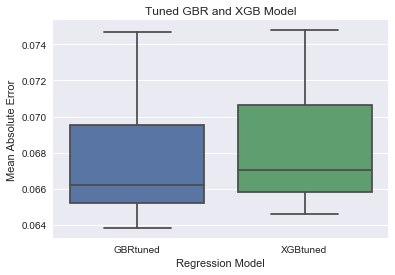

In [113]:
sns.boxplot(scores[['GBRtuned','XGBtuned']])
plt.xlabel('Regression Model')
plt.ylabel('Mean Absolute Error')
plt.title('Tuned GBR and XGB Model')
plt.show()

In [114]:
#Generate predictions where all months have the same value of logerror.
gbr2.fit(train_df_redux.drop('logerror', axis = 1), train_df_redux['logerror'])

test_data['baseline'] = gbr2.predict(test_data[['calculatedfinishedsquarefeet','lotsizesquarefeet','taxamount','yearbuilt','latitude','longitude','finishedsquarefeet12','structuretaxvaluedollarcnt','taxvaluedollarcnt']])
test_data['201610'] = test_data['baseline']
test_data['201611'] = test_data['baseline']
test_data['201612'] = test_data['baseline']
test_data['201710'] = test_data['baseline']
test_data['201711'] = test_data['baseline']
test_data['201712'] = test_data['baseline']

submission = test_data[['parcelid','201610','201611','201612','201710','201711','201712']]

submission.to_csv('gbr_regression_flat_months.csv', index=False, float_format='%.4f')

In [115]:
#Generate predictions by month based off of averages of individual months compared to avg of all data.
test_data['baseline'] = gbr2.predict(test_data[['calculatedfinishedsquarefeet','lotsizesquarefeet','taxamount','yearbuilt','latitude','longitude','finishedsquarefeet12','structuretaxvaluedollarcnt','taxvaluedollarcnt']])
test_data['201610'] = test_data['baseline'] * octlogerror/avglogerror
test_data['201611'] = test_data['baseline'] * novlogerror/avglogerror
test_data['201612'] = test_data['baseline'] * declogerror/avglogerror
test_data['201710'] = test_data['baseline'] * octlogerror/avglogerror
test_data['201711'] = test_data['baseline'] * novlogerror/avglogerror
test_data['201712'] = test_data['baseline'] * declogerror/avglogerror

submission = test_data[['parcelid','201610','201611','201612','201710','201711','201712']]

submission.to_csv('gbr_regression_month_mods_avg.csv', index=False, float_format='%.4f')

In [116]:
#Generate predictions by month based off of standard deviations of individual months compared to std of all data.
test_data['201610'] = test_data['baseline'] * octlogerrorstd/logerrorstd
test_data['201611'] = test_data['baseline'] * novlogerrorstd/logerrorstd
test_data['201612'] = test_data['baseline'] * declogerrorstd/logerrorstd
test_data['201710'] = test_data['baseline'] * octlogerrorstd/logerrorstd
test_data['201711'] = test_data['baseline'] * novlogerrorstd/logerrorstd
test_data['201712'] = test_data['baseline'] * declogerrorstd/logerrorstd

submission = test_data[['parcelid','201610','201611','201612','201710','201711','201712']]

submission.to_csv('gbr_regression_month_mods_std.csv', index=False, float_format='%.4f')

In [119]:
#Generate predictions by only training on the month being predicted for
train_df_redux2 = train_df[['parcelid','calculatedfinishedsquarefeet','lotsizesquarefeet','taxamount','logerror','yearbuilt','transactiondate','latitude','longitude','finishedsquarefeet12','structuretaxvaluedollarcnt','taxvaluedollarcnt']]
train_df_redux2['Month'] = train_df_redux2['transactiondate'].str[5:7]
del train_df_redux2['transactiondate']

gradboost = GradientBoostingRegressor(alpha=0.87, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=150,
             presort='auto', random_state=None, subsample=0.98, verbose=0,
             warm_start=False)

october = train_df_redux2[train_df_redux2['Month'] == '10'].drop(['Month','parcelid'], axis = 1)
gradboost.fit(october.drop('logerror', axis = 1), october['logerror'])
test_data['201610'] = gradboost.predict(test_data[['calculatedfinishedsquarefeet','lotsizesquarefeet','taxamount','yearbuilt','latitude','longitude','finishedsquarefeet12','structuretaxvaluedollarcnt','taxvaluedollarcnt']])
test_data['201710'] = test_data['201610']

november = train_df_redux2[train_df_redux2.Month == '11'].drop(['Month','parcelid'], axis = 1)
gradboost.fit(november.drop('logerror', axis = 1),november['logerror'])
test_data['201611'] = gradboost.predict(test_data[['calculatedfinishedsquarefeet','lotsizesquarefeet','taxamount','yearbuilt','latitude','longitude','finishedsquarefeet12','structuretaxvaluedollarcnt','taxvaluedollarcnt']])
test_data['201711'] = test_data['201611']

december = train_df_redux2[train_df_redux2.Month == '12'].drop(['Month','parcelid'], axis = 1)
gradboost.fit(december.drop('logerror', axis = 1),december['logerror'])
test_data['201612'] = gradboost.predict(test_data[['calculatedfinishedsquarefeet','lotsizesquarefeet','taxamount','yearbuilt','latitude','longitude','finishedsquarefeet12','structuretaxvaluedollarcnt','taxvaluedollarcnt']])
test_data['201712'] = test_data['201612']

submission = test_data[['parcelid','201610','201611','201612','201710','201711','201712']]

submission.to_csv('gbr_regression_by_month_ind_prediction.csv', index=False, float_format='%.4f')

C:\Users\Peter\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


PermissionError: [Errno 13] Permission denied: 'gbr_regression_by_month_ind_prediction.csv'

In [118]:
'''
split = train_df.copy()
split['logerror_grouping'] = 0
split['logerror_grouping'][(split['logerror'] <= 0.0392) & (split['logerror'] > -0.0253)] = 1
split['logerror_grouping'][split['logerror'] <= -0.0253] = 2
'''

"\nsplit = train_df.copy()\nsplit['logerror_grouping'] = 0\nsplit['logerror_grouping'][(split['logerror'] <= 0.0392) & (split['logerror'] > -0.0253)] = 1\nsplit['logerror_grouping'][split['logerror'] <= -0.0253] = 2\n"

In [ ]:
'''
#train test split on the extreme high error set, unbalance will require under/over sampling
rfc = ensemble.GradientBoostingClassifier()
split.drop(listofvariablesnottoplot, axis = 1, inplace = True)
X_train, X_test, Y_train, Y_test = train_test_split(split.drop('logerror_grouping', axis=1), split['logerror_grouping'],  test_size = 0.4)
rfc.fit(X_train, Y_train)
Y_ = rfc.predict(X_test)
print(classification_report(Y_test, Y_))
confusion = confusion_matrix(Y_test, Y_)
eval_con_mat(confusion)
print(confusion)
mse = mean_squared_error(Y_test, Y_)
print('Mean squared error:{}'.format(mse))
'''